In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

plt.rcParams.update({"figure.figsize": (7, 4), "axes.grid": False})

ANNOTATORS = ["Armita", "Tharu", "Samaneh", "Ashley", "Rimona"]
PRED_COL = "prediction label"
PROV_COL = "Province"

YES_VALUES = {"yes", "y", "true", "1"}
NO_VALUES  = {"no", "n", "false", "0"}

In [2]:
# label helpers

def normalize_label_raw(x):
    """Map messy label values into yes no or NaN."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in YES_VALUES:
        return "yes"
    if s in NO_VALUES:
        return "no"
    return np.nan


def norm_label(x):
    """Simple normalizer used inside annotator analysis."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s == "yes":
        return "yes"
    if s == "no":
        return "no"
    return np.nan


# load and clean one csv

def load_data(csv_path):
    """
    Load and clean one csv into the standard format for evaluation.
    Returns a cleaned dataframe.
    """
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)

    # clean "name only" variants
    df = df.apply(
        lambda col: col.astype(str).str.replace(
            r'\bname\s*alone\b',
            'name only',
            regex=True,
            case=False
        )
    )

    # normalize method names into "websearch"
    df = df.apply(
        lambda col: col.astype(str)
        .str.lower()
        .str.strip()
        .str.replace(
            r'\b(name\s*\+\s*url|name\s*and\s*url|url|link|website|web\s*search|search\s*web|using\s*web)\b',
            'websearch',
            regex=True
        )
    )

    # normalize main label and prediction column to yes no
    if "Label" in df.columns:
        df["Label"] = df["Label"].map(normalize_label_raw)

    if PRED_COL in df.columns:
        df[PRED_COL] = df[PRED_COL].map(normalize_label_raw)

    return df


In [3]:
# core analysis helpers 

def label_distribution(df, include_pred=True):
    cols = ["Label"] + ([PRED_COL] if include_pred else [])
    summary = []
    for col in cols:
        if col in df:
            summary.append(
                {
                    "column": col,
                    "yes": (df[col] == "yes").sum(),
                    "no": (df[col] == "no").sum(),
                    "total": len(df),
                }
            )
    if summary:
        return pd.DataFrame(summary).set_index("column")
    else:
        return pd.DataFrame()


def plot_annotator_distribution(df):
    label_cols = [f"Label-{a}" for a in ANNOTATORS]
    label_cols = [c for c in label_cols if c in df.columns]
    if not label_cols:
        print("No annotator label columns found")
        return

    clean = df[label_cols].replace({"": np.nan, "nan": np.nan, "None": np.nan})
    counts = clean.notna().sum().sort_values(ascending=False)

    df["num_annotators"] = clean.notna().sum(axis=1)
    overlap = df["num_annotators"].value_counts().sort_index()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    counts.plot(kind="bar", ax=ax[0], title="Records per annotator")
    ax[0].bar_label(ax[0].containers[0], labels=[f"{v}" for v in counts.values], padding=3)

    overlap.plot(kind="bar", ax=ax[1], title="Records by number of annotators")
    ax[1].bar_label(ax[1].containers[0], labels=[f"{v}" for v in overlap.values], padding=3)

    plt.tight_layout()
    plt.show()


def method_usage(df):
    methods = [c for c in df.columns if c.startswith("Approach-")]
    if not methods:
        print("No Approach-* columns found")
        return pd.DataFrame()

    long = df[methods].copy()
    long.columns = [c.replace("Approach-", "") for c in long.columns]
    long = long.melt(var_name="annotator", value_name="method")

    long["method_norm"] = long["method"].astype(str).str.strip().str.lower()
    tbl = (
        long.groupby(["annotator", "method_norm"], dropna=False)
        .size()
        .reset_index(name="count")
        .sort_values(["annotator", "count"], ascending=[True, False])
    )
    return tbl


def error_rate_by_province(df, pred_col=PRED_COL, plot=True):
    tmp = df.copy()
    tmp["is_error"] = (tmp["Label"] != tmp[pred_col]).astype(int)

    summary = (
        tmp.groupby(PROV_COL, dropna=False)["is_error"]
        .agg(error_rate="mean", n="count")
        .reset_index()
        .sort_values("error_rate", ascending=False)
    )

    if plot and not summary.empty:
        summary.plot.bar(
            x=PROV_COL,
            y="error_rate",
            title=f"Error rate by province ({pred_col})",
            legend=False,
        )
        plt.tight_layout()
        plt.show()

    return summary


def error_rate_by_method(df, pred_col=PRED_COL, plot=True):
    tmp = df.copy()
    tmp["is_error"] = (tmp["Label"] != tmp[pred_col]).astype(int)

    methods = [c for c in tmp.columns if c.startswith("Approach-")]
    if not methods:
        print("No Approach-* columns found")
        return pd.DataFrame()

    melted = tmp.melt(
        id_vars="is_error",
        value_vars=methods,
        var_name="approach_col",
        value_name="method",
    ).dropna(subset=["method"])

    summary = (
        melted.groupby("method", as_index=False)["is_error"]
        .mean()
        .rename(columns={"is_error": "error_rate"})
        .sort_values("error_rate", ascending=False)
    )

    if plot and not summary.empty:
        summary.plot.bar(
            x="method",
            y="error_rate",
            title=f"Error rate by method ({pred_col})",
            legend=False,
        )
        plt.tight_layout()
        plt.show()

    return summary


def annotator_error_table(df, pred_col=PRED_COL):
    pred = df[pred_col].map(norm_label)
    rows = []

    for ann in ANNOTATORS:
        col = f"Label-{ann}"
        if col not in df.columns:
            continue

        ann_labels = df[col].map(norm_label)
        valid = ann_labels.notna() & pred.notna()
        if valid.sum() == 0:
            continue

        a = ann_labels[valid]
        p = pred[valid]
        disagree = a != p

        rows.append(
            {
                "annotator": ann,
                "n_labeled": valid.sum(),
                "n_disagreements": disagree.sum(),
                "disagree_rate": disagree.mean(),
                "FP (model yes / annot no)": ((a == "no") & (p == "yes")).sum(),
                "FN (model no / annot yes)": ((a == "yes") & (p == "no")).sum(),
            }
        )

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).sort_values("disagree_rate", ascending=False)


In [4]:
# one function for full evaluation of any model 

def full_eval(
    df_eval,
    label_col="Label",
    pred_col=PRED_COL,
    label="Model evaluation",
    province_filter=None,
    drop_provinces=None,
    verbose=True,
):
    df_test = df_eval.copy()

    if province_filter is not None:
        df_test = df_test[df_test[PROV_COL].isin(province_filter)]

    if drop_provinces is not None:
        df_test = df_test[~df_test[PROV_COL].isin(drop_provinces)]

    y_true = df_test[label_col]
    y_pred = df_test[pred_col]

    if verbose:
        
        print(f"{label}")
        print(f"Rows in evaluation: {len(df_test)}\n")

        dist = label_distribution(df_test, include_pred=True)
        if not dist.empty:
            print("Label distribution:")
            print(dist, "\n")

        province_counts = (
            df_test[PROV_COL]
            .value_counts(dropna=False)
            .rename_axis(PROV_COL)
            .reset_index(name="n")
        )
        print("Province counts:")
        print(province_counts, "\n")

        print("Confusion matrix:")
        cm = confusion_matrix(y_true, y_pred, labels=["yes", "no"])
        print(cm, "\n")

        print("Classification report:")
        print(classification_report(y_true, y_pred, labels=["yes", "no"], digits=3))

    acc = accuracy_score(y_true, y_pred)

    if verbose:
        print(f"\nAccuracy: {acc:.3f}\n")

        print("Error rate by province:")
        print(error_rate_by_province(df_test, pred_col=pred_col, plot=True), "\n")

        print("Error rate by method:")
        print(error_rate_by_method(df_test, pred_col=pred_col, plot=True), "\n")

        print("Annotator disagreement:")
        print(annotator_error_table(df_test, pred_col=pred_col))

    return acc


In [5]:
# export false positives and false negatives 

def export_fp_fn(
    df,
    pred_col=PRED_COL,
    actual_col="Label",
    path="hallucination_review.xlsx",
):
    fn = df[(df[actual_col] == "yes") & (df[pred_col] == "no")].copy()
    fp = df[(df[actual_col] == "no") & (df[pred_col] == "yes")].copy()

    print(f"False negatives: {len(fn)}   False positives: {len(fp)}")

    with pd.ExcelWriter(path, engine="openpyxl") as writer:
        fn.to_excel(writer, sheet_name="False negatives", index=False)
        fp.to_excel(writer, sheet_name="False positives", index=False)

    print(f"Saved to {path}")

Web_Search
Rows in evaluation: 425

Label distribution:
                  yes   no  total
column                           
Label             212  213    425
prediction label  222  203    425 

Province counts:
  Province    n
0       on  345
1       qc   74
2       ab    5
3      nan    1 

Confusion matrix:
[[194  18]
 [ 28 185]] 

Classification report:
              precision    recall  f1-score   support

         yes      0.874     0.915     0.894       212
          no      0.911     0.869     0.889       213

    accuracy                          0.892       425
   macro avg      0.893     0.892     0.892       425
weighted avg      0.893     0.892     0.892       425


Accuracy: 0.892

Error rate by province:


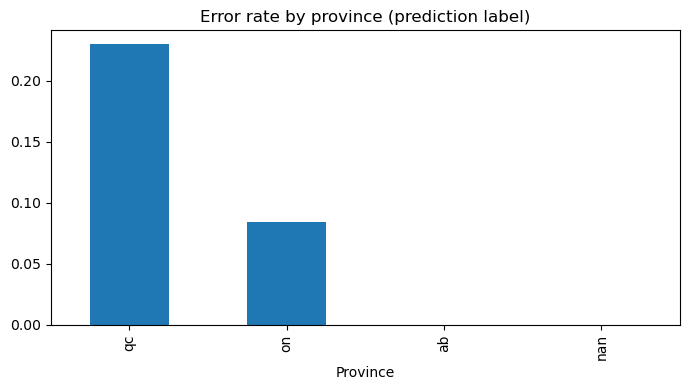

  Province  error_rate    n
3       qc    0.229730   74
2       on    0.084058  345
0       ab    0.000000    5
1      nan    0.000000    1 

Error rate by method:


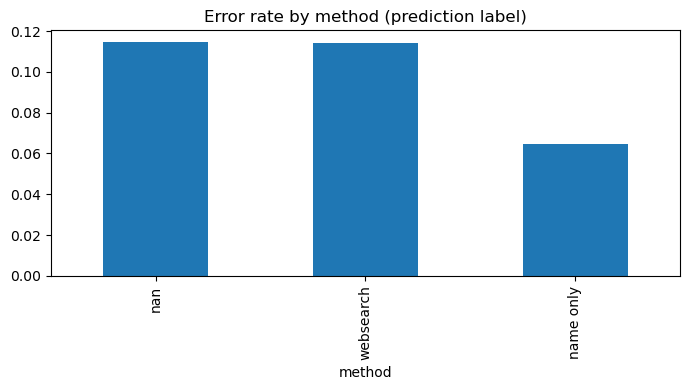

      method  error_rate
1        nan    0.114607
2  websearch    0.114094
0  name only    0.064815 

Annotator disagreement:
  annotator  n_labeled  n_disagreements  disagree_rate  \
3    Ashley         79               17       0.215190   
4    Rimona        175               17       0.097143   
1     Tharu        124               10       0.080645   
0    Armita         67                5       0.074627   
2   Samaneh        171               12       0.070175   

   FP (model yes / annot no)  FN (model no / annot yes)  
3                         16                          1  
4                          3                         14  
1                          7                          3  
0                          3                          2  
2                          9                          3  


0.8917647058823529

In [6]:
df = load_data("02_Web-Canada-v5_output - 02_Web-Canada-v5_output.csv")
full_eval(df, pred_col="prediction label", label="Web_Search")

Without Quebec
Rows in evaluation: 351

Label distribution:
                  yes   no  total
column                           
Label             207  144    351
prediction label  202  149    351 

Province counts:
  Province    n
0       on  345
1       ab    5
2      nan    1 

Confusion matrix:
[[190  17]
 [ 12 132]] 

Classification report:
              precision    recall  f1-score   support

         yes      0.941     0.918     0.929       207
          no      0.886     0.917     0.901       144

    accuracy                          0.917       351
   macro avg      0.913     0.917     0.915       351
weighted avg      0.918     0.917     0.918       351


Accuracy: 0.917

Error rate by province:


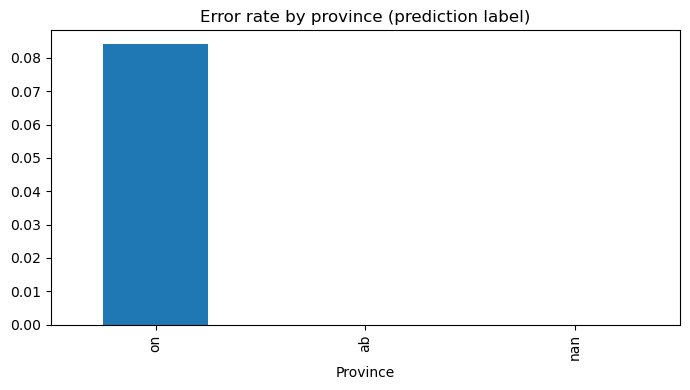

  Province  error_rate    n
2       on    0.084058  345
0       ab    0.000000    5
1      nan    0.000000    1 

Error rate by method:


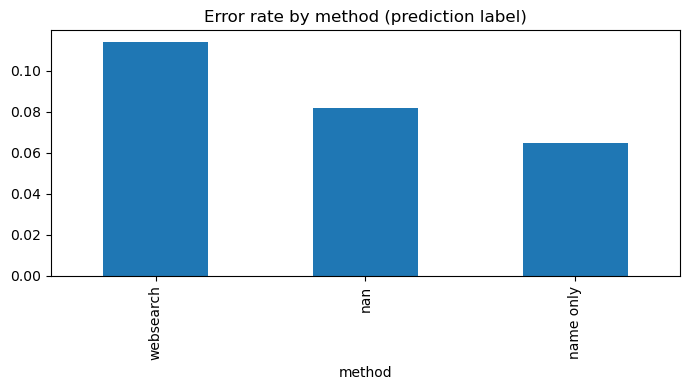

      method  error_rate
2  websearch    0.114094
1        nan    0.081809
0  name only    0.064815 

Annotator disagreement:
  annotator  n_labeled  n_disagreements  disagree_rate  \
4    Rimona        175               17       0.097143   
1     Tharu        124               10       0.080645   
0    Armita         67                5       0.074627   
2   Samaneh        171               12       0.070175   
3    Ashley          5                0       0.000000   

   FP (model yes / annot no)  FN (model no / annot yes)  
4                          3                         14  
1                          7                          3  
0                          3                          2  
2                          9                          3  
3                          0                          0  


0.9173789173789174

In [7]:
full_eval(df, pred_col="prediction label", label="Without Quebec", drop_provinces=["qc"])


Websearch - Rimona's Labels
Rows in evaluation: 425

Label distribution:
                  yes   no  total
column                           
Label             223  202    425
prediction label  222  203    425 

Province counts:
  Province    n
0       on  345
1       qc   74
2       ab    5
3      nan    1 

Confusion matrix:
[[204  19]
 [ 18 184]] 

Classification report:
              precision    recall  f1-score   support

         yes      0.919     0.915     0.917       223
          no      0.906     0.911     0.909       202

    accuracy                          0.913       425
   macro avg      0.913     0.913     0.913       425
weighted avg      0.913     0.913     0.913       425


Accuracy: 0.913

Error rate by province:


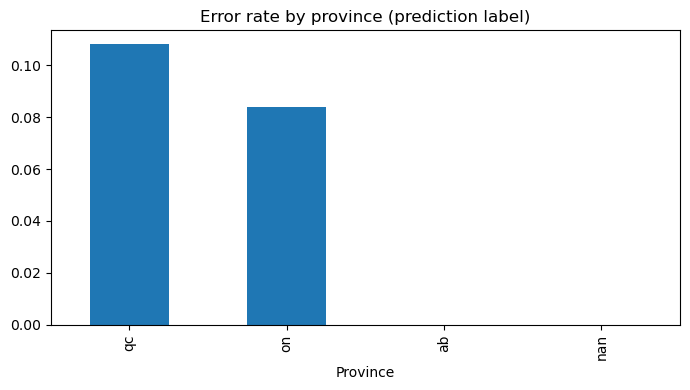

  Province  error_rate    n
3       qc    0.108108   74
2       on    0.084058  345
0       ab    0.000000    5
1      nan    0.000000    1 

Error rate by method:


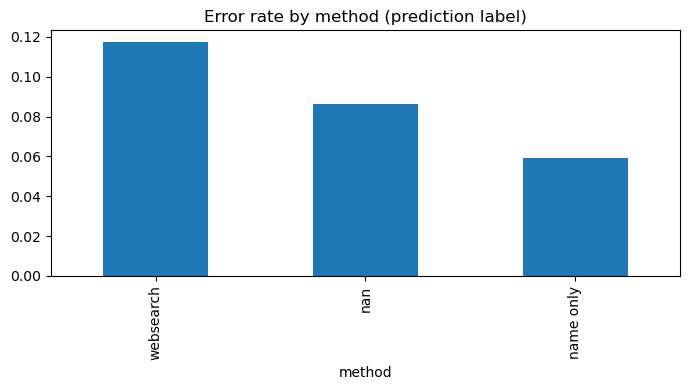

      method  error_rate
2  websearch    0.117438
1        nan    0.086122
0  name only    0.059072 

Annotator disagreement:
  annotator  n_labeled  n_disagreements  disagree_rate  \
3    Ashley         79                8       0.101266   
4    Rimona        175               17       0.097143   
1     Tharu        124               10       0.080645   
0    Armita         67                5       0.074627   
2   Samaneh        171               12       0.070175   

   FP (model yes / annot no)  FN (model no / annot yes)  
3                          6                          2  
4                          3                         14  
1                          7                          3  
0                          3                          2  
2                          9                          3  


0.9129411764705883

In [8]:
df_updatedlabels = load_data("02_Web-Canada-v5_output_UPDATED_Rimona_QC.csv")
full_eval(df_updatedlabels, pred_col="prediction label", label="Websearch - Rimona's Labels")

In [9]:
export_fp_fn(
    df,
    pred_col=PRED_COL,
    actual_col="Label",
    path="web_hallucination_review.xlsx",
)
    
df_no_qc = df[df["Province"].str.lower() != "qc"].copy()

export_fp_fn(
    df_no_qc,
    pred_col="prediction label",
    actual_col="Label",
    path="web_hallucination_review_without_QC.xlsx"
)

export_fp_fn(
    df_updatedlabels,
    pred_col="prediction label",
    actual_col="Label",
    path="web_hallucination_review_Rimona_labels.xlsx"
)



False negatives: 18   False positives: 28
Saved to web_hallucination_review.xlsx
False negatives: 17   False positives: 12
Saved to web_hallucination_review_without_QC.xlsx
False negatives: 19   False positives: 18
Saved to web_hallucination_review_Rimona_labels.xlsx
